# -------------------------------------------------------------------------#

# 1. Predict ratings using Matrix Completion

# -------------------------------------------------------------------------#

In [1]:
import numpy as np
import argparse
import pickle
import time

from scipy.sparse.linalg import svds

In [2]:
class arguments():
    # Set Path
    DATAPATH = '../../datasets/'
    RESULTPATH = '../results/'
    metadata = 'False'
    fillnan='mean_col'
    sim_method='cosine_similarity'
    norm_laplacian_k=5
    normalize_laplacian='False'
    kmeans_k=5
    n_epochs=10
    test_prc=0.25
    graph_nodes='M'
    
args = arguments()

In [3]:
"""
Reading and preprocessing data
"""
import numpy as np
import pandas as pd
import pickle
import time

def read_preprocss_data(args):
    time_start=time.time()
    # args.DATAPATH = '../datasets/'
    train = pd.read_csv(args.DATAPATH + 'train.csv')
    test = pd.read_csv(args.DATAPATH + 'test.csv')

    train.columns = ['movie_id', 'customer_id', 'rating', 'date']
    test.columns  = ['movie_id', 'customer_id', 'rating', 'date']

    df = train.pivot_table(index='customer_id', \
                               columns='movie_id', values='rating', aggfunc=np.mean).fillna(0)
    A_fill_zeros = df.to_numpy().copy()

    if args.fillnan=='mean_col':
        df = train.pivot_table(index='customer_id', \
                               columns='movie_id', values='rating', aggfunc=np.mean)
        A = df.to_numpy().copy()
        # column mean
        col_mean = np.nanmean(A, axis = 0)
        col_mean = np.ceil(col_mean)
        print(col_mean.shape)
        col_mean[col_mean>5]=5
        # find indices where nan value is present
        inds = np.where(np.isnan(A))
        # replace inds with avg of column
        A[inds] = np.take(col_mean, inds[1])
    elif args.fillnan=='mean_row':
        df = train.pivot_table(index='customer_id', \
                               columns='movie_id', values='rating', aggfunc=np.mean)
        A = df.to_numpy().copy()
        # row mean
        row_mean = np.nanmean(A, axis = 1)
        row_mean = np.ceil(row_mean)
        # find indices where nan value is present
        inds = np.where(np.isnan(A))
        # replace inds with avg of column
        A[inds] = np.take(row_mean, inds[1])

    print('Reading time elapsed: {} sec'.format(time.time()-time_start))
    print('Reading is done, the shape of the data is:', A.shape)
    

    return df, A, A_fill_zeros





"""
Generating similarity matrix
"""

import numpy as np
import pickle
from sklearn.metrics.pairwise import sigmoid_kernel, cosine_similarity


def gen_similarity(args, X):

    if args.sim_method=='sigmoid_kernel':
        sim_UXU=sigmoid_kernel(X=X, Y=None, gamma=None, coef0=1)
        sim_MXM=sigmoid_kernel(X=X.T, Y=None, gamma=None, coef0=1)
    elif args.sim_method=='cosine_similarity':
        sim_UXU=cosine_similarity(X=X, Y=None)
        sim_MXM=cosine_similarity(X=X.T, Y=None)
    ## =====================================================================
#     # Save similarity matrix
#     fn_str = args.RESULTPATH + 'sim_%s_UXU.npy' %(args.sim_method)
#     with open(fn_str, 'wb') as f:
#         pickle.dump(sim_UXU, f)

#     fn_str = args.RESULTPATH + 'sim_%s_MXM.npy' %(args.sim_method)
#     with open(fn_str, 'wb') as f:
#         pickle.dump(sim_MXM, f)
#     print('saving similarity matrix is done!')
    ## =====================================================================
    return sim_UXU, sim_MXM




"""
Calculating the Laplacian matrix
"""

import numpy as np
import time

def calc_laplacian(args, Ws):
    t1 = time.time()
    # degree matrix
    D = np.diag(np.sum(np.array(Ws), axis=1))
    print('degree matrix:')
    print(D.shape)
    # laplacian matrix
    L = D - Ws
    print('laplacian matrix:')
    print(L.shape)
    elapsed_time = time.time() - t1
    print('Elapsed time is {} seconds: '.format(elapsed_time))

    return L, D




"""
Calculate eigen vectors and values of the input
"""

import numpy as np
import time

# from numpy import linalg as LA
# from scipy.sparse import linalg
# from scipy.linalg import eig as LAeig
# from scipy import linalg
from scipy.sparse.linalg import eigsh


def calc_eig(args, L, Ws, kk):
    t1 = time.time()
    D=np.diag(np.sum(Ws, axis=0))
    vol=np.sum(np.diag(D))

    vals, vecs = eigsh(L, k=kk, which="SM")  # Largest 5 eigenvalues/vectors
    vecs = vecs.real

    print('the first 10 eigen values are:')
    print(vals[:10])
    print('\n')

    if (vals[0]==0):
        if vals[1] > 0:
            print('OOOPS the first eigen value was zero')
            vals = vals[1:]
            vecs = vecs[:,1:]
    if (vals[0]<1e-10):
        print('OOOPS the first eigen value was so small')
        vals = vals[1:]
        vecs = vecs[:,1:]

    #caluclate eigen gap
    e1 = np.zeros([vals.shape[0]+1])
    e2 = np.zeros([vals.shape[0]+1])
    print(e1.shape)
    e1[1:] = vals.copy()
    e2[:-1] = vals.copy()
    print('eigen gap is:')
    eigengap=(e2-e1)
    print(eigengap)
    print('the first 10 eigen values are:')
    print(vals[:10])
    print('\n')
    #


    # eigenvalues
    print('eigenvalues shape is:')
    print(vals.shape)
    # eigenvectors
    print('eigenvectors shape is :')
    print(vecs.shape)
    if args.normalize_laplacian:
        print('do the normalization')
        Y = np.sort(vals)
        I = np.argsort(vals)
        v_norm = vecs[:,I[:args.norm_laplacian_k]] \
            / LA.norm(vecs[:,I[:args.norm_laplacian_k]])*vol**(1/2)
    else:
        v_norm = []
    elapsed_time = time.time() - t1
    print('Elapsed time is {} seconds: '.format(elapsed_time))
    print('calc eigen vectors and values done!')
    return vals, vecs, v_norm, eigengap



In [4]:
df, A, A_fill_zeros = read_preprocss_data(args)
print('done reading the data')

data = A.copy()
data_fill_zeros = A_fill_zeros.copy()
print('data shape is:', data.shape)
print('data fill zero shape is:', data_fill_zeros.shape)
#===========================================================================
#=======================================================================
test = pd.read_csv(args.DATAPATH + 'test.csv')
test.columns  = ['movie_id', 'customer_id', 'rating', 'date']
test_np = test.to_numpy().copy()

train = pd.read_csv(args.DATAPATH + 'train.csv')
train.columns  = ['movie_id', 'customer_id', 'rating', 'date']
train_np = train.to_numpy().copy()

train_data = data.copy()

(16142,)
Reading time elapsed: 31.96229100227356 sec
Reading is done, the shape of the data is: (5905, 16142)
done reading the data
data shape is: (5905, 16142)
data fill zero shape is: (5905, 16142)


In [5]:
movie_to_index = {movie:indx for indx, movie in enumerate(df.columns.values)}
customer_to_index = {customer:indx for indx, customer in enumerate(df.index.values)}
index_to_movie = {indx:movie for indx, movie in enumerate(df.columns.values)}

In [6]:
#=======================================================================
final_k = 5
#=======================================================================
time_start=time.time()

train_data = data.copy()
U, sigmaTmp, Vt = svds(train_data, k = final_k)
sigma = np.zeros([sigmaTmp.shape[0], sigmaTmp.shape[0]])
np.fill_diagonal(sigma, sigmaTmp)
pred_ratings = np.dot(np.dot(U, sigma), Vt)
print('pred_ratings time elapsed: {} sec'.format(time.time()-time_start))

pred_ratings time elapsed: 6.426725149154663 sec


In [7]:
# if args.graph_nodes=='M': # menas the sim is MXM
    
#     time_start=time.time()
#     existed=0
#     for ic in range(len(test_np)):    
#         mvid   = test_np[ic, 0]
#         custid = test_np[ic, 1]
#         if mvid not in movie_to_index.keys():
#             test_np[ic,2] = -1
#             continue
#         if custid not in customer_to_index.keys():
#             test_np[ic,2] = -1
#             continue
#         existed_rate = train[(train["movie_id"]==mvid)&(train["customer_id"]==custid)]

#         if (existed_rate.empty):
#             indx_mv   = movie_to_index[mvid]
#             indx_cust = customer_to_index[custid]
#             pr = np.ceil(pred_ratings[indx_cust, indx_mv])
#             if pr > 5:
#                 test_np[ic,2] = 5
#             else:
#                 test_np[ic,2] = pr
#         else:
#             existed+=1
#             test_np[ic,2] = existed_rate
#         if ic%100000==0:
#             print('ic:', ic)
#             print(test_np)
#             # Save movie titles
#             fn_str = args.RESULTPATH + 'test_np_MatrixCompletition_k5'
#             with open(fn_str, 'wb') as f:
#                 pickle.dump(test_np, f)
#             print('Creating movie titles time elapsed: {} sec'.format(time.time()-time_start))
#     print('existed:', existed)
   

In [8]:
# test_df = pd.DataFrame(data=test_np, columns=['movie_id', 'customer_id', 'rating', 'date'])
# fn_str = args.RESULTPATH + 'MaryZolfaghar_preds_matrix_k5.csv'
# with open(fn_str, 'wb') as f:
#     pickle.dump(test_df, f)
# print('Creating movie titles time elapsed: {} sec'.format(time.time()-time_start))

# visulization 

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

import time


def plot_clusters(data_plot, labels, labels_txt, final_k):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_plot)

    xx = tsne_results[:,0]
    yy = tsne_results[:,1]

    plt.figure(figsize=(14,10))
    sns.scatterplot(
        x=xx, y=yy,
        hue=labels,
        palette=sns.color_palette("hls", final_k),
        legend="full",
        alpha=0.3)
    fig, ax = plt.subplots()
    ax.scatter(z, y)

    for i, txt in enumerate(n):
        ax.annotate(txt, (z[i], y[i]))

In [11]:
t1=[]; t2=[]; t3=[]
with open(args.DATAPATH + 'movie_titles.txt', 'r',encoding="latin-1") as reading:
    for line in reading.readlines():
        tokens = line.split(",")
        t1.append(tokens[0])
        t2.append(tokens[1])
        t33 = tokens[2].split('\n')
        t3.append(t33[0])

t1=np.asarray(t1)
t1=t1[1:]
t2=np.asarray(t2)
t2=t2[1:]
t3=np.asarray(t3)
t3=t3[1:]

titles = pd.read_fwf(args.DATAPATH + 'movie_titles.txt', delimiter= ',', \
                           names = ["movie_id", "year_produced", "title"], encoding="ISO-8859-1")


movie_titles = pd.DataFrame(titles[1:], columns=["movie_id", "year_produced", "title"])

movie_titles['movie_id'] = t1
movie_titles['year_produced'] = t2
movie_titles['title'] = t3

movie_titles



,movie_id,year_produced,title
1,1,2003,Dinosaur Planet
2,2,2004,Isle of Man TT 2004 Review
3,3,1997,Character
4,4,1994,Paula Abdul's Get Up & Dance
5,5,2004,The Rise and Fall of ECW
...,...,...,...
17766,17766,2002,Where the Wild Things Are and Other Maurice Se...
17767,17767,2004,Fidel Castro: American Experience
17768,17768,2000,Epoch
17769,17769,2003,The Company


In [54]:
movieid_to_title = {movie:title for (movie, title) in zip(movie_titles['movie_id'], movie_titles['title'])}

In [23]:
movie_to_index = {movie:indx for indx, movie in enumerate(df.columns.values)}
customer_to_index = {customer:indx for indx, customer in enumerate(df.index.values)}
index_to_movie = {indx:movie for indx, movie in enumerate(df.columns.values)}

In [40]:
titles=[]
for ii in range(Vt.T.shape[0]):
    mvid = index_to_movie[ii]
#     print(mvid)
    str_mvid = str(mvid)
#     print(movieid_to_title[str_mvid])
    titles.append(movieid_to_title[str_mvid])
print(len(titles))
titles


16142


['Dinosaur Planet',
 'Isle of Man TT 2004 Review',
 'Character',
 "Paula Abdul's Get Up & Dance",
 'The Rise and Fall of ECW',
 'Sick',
 'What the #$*! Do We Know!?',
 'Full Frame: Documentary Shorts',
 'My Favorite Brunette',
 'Nature: Antarctica',
 'Neil Diamond: Greatest Hits Live',
 'Screamers',
 '7 Seconds',
 'Immortal Beloved',
 "By Dawn's Early Light",
 'Strange Relations',
 'Chump Change',
 "Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo",
 'My Bloody Valentine',
 'Inspector Morse 31: Death Is Now My Neighbour',
 'Never Die Alone',
 "Sesame Street: Elmo's World: The Street We Live On",
 'Lilo and Stitch',
 'Boycott',
 "Something's Gotta Give",
 'Classic Albums: Meat Loaf: Bat Out of Hell',
 "ABC Primetime: Mel Gibson's The Passion of the Christ",
 'Aqua Teen Hunger Force: Vol. 1',
 'Ferngully 2: The Magical Rescue',
 'Lady Chatterley',
 "Zatoichi's Conspiracy",
 'Daydream Obsession',
 'Love Reinvented',
 'Pitcher and the Pin-Up',
 'Searching for Paradise',

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data_plot = Vt.T.copy()
km_labels=''
labels_txt=titles


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_plot)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16142 samples in 0.009s...
[t-SNE] Computed neighbors for 16142 samples in 0.988s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16142
[t-SNE] Computed conditional probabilities for sample 2000 / 16142
[t-SNE] Computed conditional probabilities for sample 3000 / 16142
[t-SNE] Computed conditional probabilities for sample 4000 / 16142
[t-SNE] Computed conditional probabilities for sample 5000 / 16142
[t-SNE] Computed conditional probabilities for sample 6000 / 16142
[t-SNE] Computed conditional probabilities for sample 7000 / 16142
[t-SNE] Computed conditional probabilities for sample 8000 / 16142
[t-SNE] Computed conditional probabilities for sample 9000 / 16142
[t-SNE] Computed conditional probabilities for sample 10000 / 16142
[t-SNE] Computed conditional probabilities for sample 11000 / 16142
[t-SNE] Computed conditional probabilities for sample 12000 / 16142
[t-SNE] Computed conditional probabilities for sa

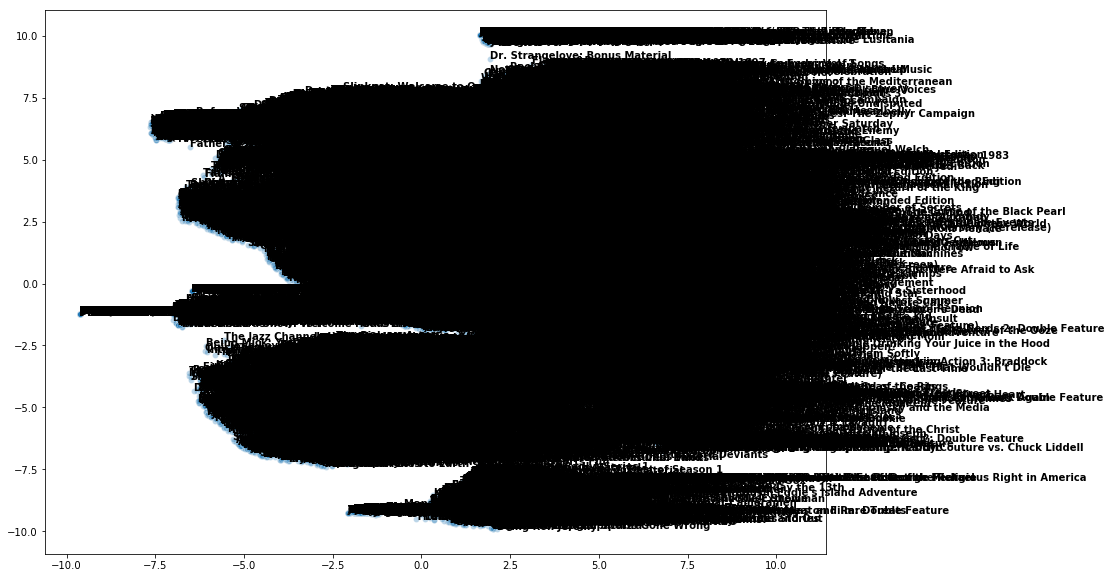

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import time


xx = tsne_results[:,0]
yy = tsne_results[:,1]
labels=''
txt= labels_txt
ax, fig = plt.subplots(1,1,figsize=(14,10))
p1=sns.scatterplot(x=xx, y=yy,
#                 hue=labels,
                palette=sns.color_palette("hls", final_k),
                legend="full",
                alpha=0.3)

for i, txt in enumerate(txt):
    p1.text(xx[i], yy[i], txt, horizontalalignment='left', size='medium', color='black', weight='semibold')